<a href="https://colab.research.google.com/github/adamlutzz/AB-Demo/blob/master/Unit_2_Sprint_3_SG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 2 Sprint 3 Applied Modeling: Study Guide

For your sprint challenge, please be prepared to:<br/><br/>
1) **Pre-Processing**<br/>
You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. How do you deal with leakage?<br/><br/>
2) **Modeling**<br/>
Fit a model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and estimate your ROC AUC validation score.<br/><br/>
3) **Visualization**<br/>
Make visualizations for model interpretation, including some or all of these:<br/>
*   Permutation Importances<br/>
*   Partial Dependence Plot<br/>
*  Shapley Values<br/>

### Setup

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:

    # Install required python packages
    !pip install -r 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/requirements.txt'

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 112kB 20.5MB/s 
     |████████████████████████████████| 133kB 53.9MB/s 
     |████████████████████████████████| 57.7MB 500kB/s 
     |████████████████████████████████| 245kB 43.2MB/s 
     |████████████████████████████████| 614kB 39.7MB/s 
     |████████████████████████████████| 235kB 44.3MB/s 
     |████████████████████████████████| 307kB 47.2MB/s 
     |████████████████████████████████| 51kB 22.2MB/s 
     |████████████████████████████████| 215kB 15.7MB/s 
     |████████████████████████████████| 51kB 17.9MB/s 
     |████████████████████████████████| 737kB 39.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=d9bdb25e0250bf96c34181677d75686a51a5c8f1c9960725ea3113b5f2213a21
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for pdpbox: filename=PDPbox-0.2.0-

##Pre-Processing

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling

link ='https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv'

df = pd.read_csv(link)

print(df.shape)
df.head()

(11500, 180)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [46]:
# create target feature with binary condition for seizure
df['seizure'] = df['y'] == 1

# check work
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y,seizure
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4,False
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1,True
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5,False
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5,False
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5,False


In [47]:
# what is the baseline?
df['seizure'].value_counts(normalize=True)

False    0.8
True     0.2
Name: seizure, dtype: float64

In [48]:
# fix column 1 header
df.rename( columns={'Unnamed: 0':'id'}, inplace=True )
df.head()

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y,seizure
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4,False
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1,True
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5,False
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5,False
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5,False


In [49]:
# are all id's unique?
df['id'].nunique()

11500

In [0]:
def wrangle(df):
    
    # prevent copy warning
    df = df.copy()

    # Drop features with unsable variance or high missing values
    unusable_variance = ['id', 'y']
    df = df.drop(columns=unusable_variance)

    return df

In [0]:
df = wrangle(df)

In [58]:
from sklearn.model_selection import train_test_split

# 80/20 train test split
train, test = train_test_split(df, test_size=.20, stratify=df['seizure'],
                               random_state=11)
# confirm size
train.shape, test.shape

((9200, 179), (2300, 179))

In [59]:
# validation set
train, val = train_test_split(train, test_size=.20, stratify=train['seizure'],
                              random_state=11)
# confirm size
train.shape, val.shape

((7360, 179), (1840, 179))

In [0]:
# create target
target = 'seizure'

# create X_features matrix and y_target vector for train
X_train = train.drop(columns=target)
y_train = train[target]

# create X_features matrix and y_target vector for val
X_val = val.drop(columns=target)
y_val = val[target]

# create X_features matrix and y_target vector for test
X_test = test.drop(columns=target)
y_test = test[target]

In [0]:
# imports for pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Make pipeline!
RF = make_pipeline( 
    RandomForestClassifier(random_state=11, n_jobs=-1)
)

In [62]:
# Fit on train, score on val
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation Accuracy 0.9657608695652173


### ROC AUC

In [0]:
y_true = df[target]

In [0]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

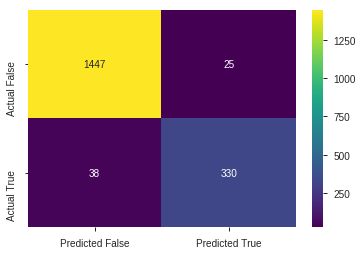

In [66]:
plot_confusion_matrix(y_val, y_pred);

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.98      1472
        True       0.93      0.90      0.91       368

    accuracy                           0.97      1840
   macro avg       0.95      0.94      0.95      1840
weighted avg       0.97      0.97      0.97      1840



In [68]:
from sklearn.metrics import roc_auc_score

y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [69]:
y_val.value_counts()

False    1472
True      368
Name: seizure, dtype: int64

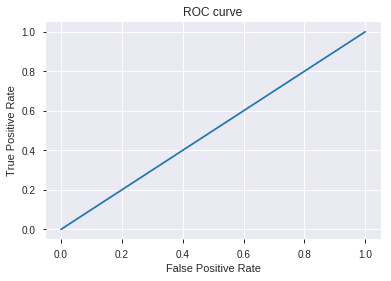

In [71]:
# plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==True, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [72]:
# ROC Score
y_pred_proba = RF.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.9876222087665406

In [73]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

### Permutation Importances

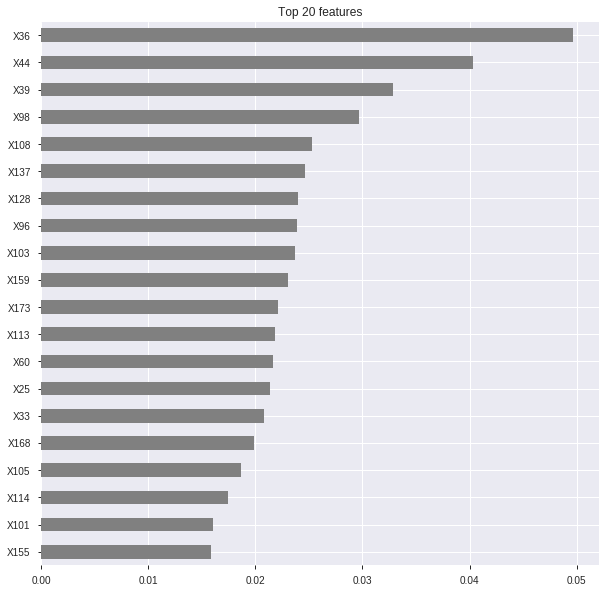

In [75]:
# Get feature importances
rand_f = RF.named_steps['randomforestclassifier']
importances = pd.Series(rand_f.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [77]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [78]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0011 ± 0.0011,X20
0.0011 ± 0.0000,X162
0.0011 ± 0.0000,X160
0.0008 ± 0.0005,X1
0.0008 ± 0.0005,X142
0.0008 ± 0.0005,X125
0.0008 ± 0.0005,X159
0.0005 ± 0.0000,X123
0.0005 ± 0.0000,X122
0.0005 ± 0.0000,X140


In [79]:
# Remove features with zero or less feature importance
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

X_train.shape

(7360, 56)

In [80]:
# apply to validation as well
X_val = X_val[features]
X_val.shape

(1840, 56)

In [81]:
pipeline = make_pipeline(
    
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)

)

pipeline.fit(X_train, y_train)
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.9690217391304348


### Partial Dependence Plots

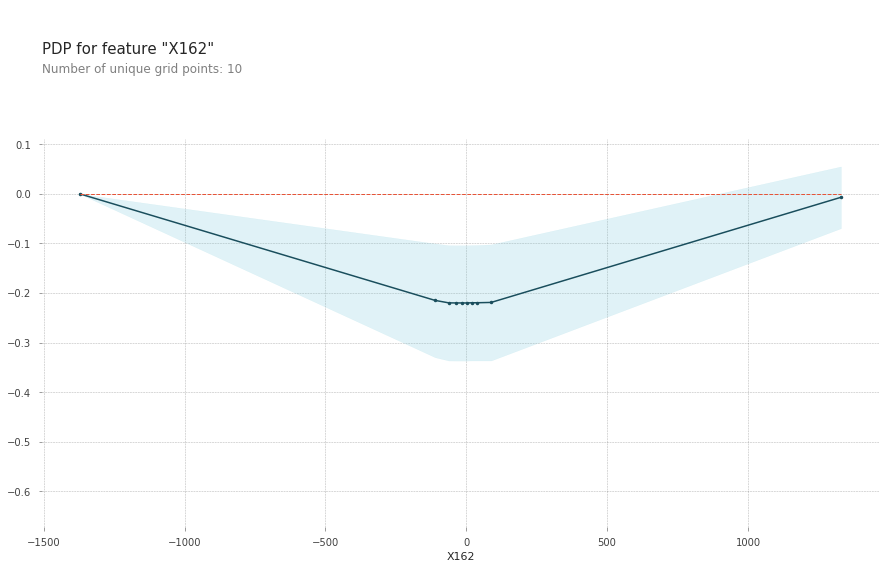

In [84]:
# single feature partial dependency plot
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'X162'

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

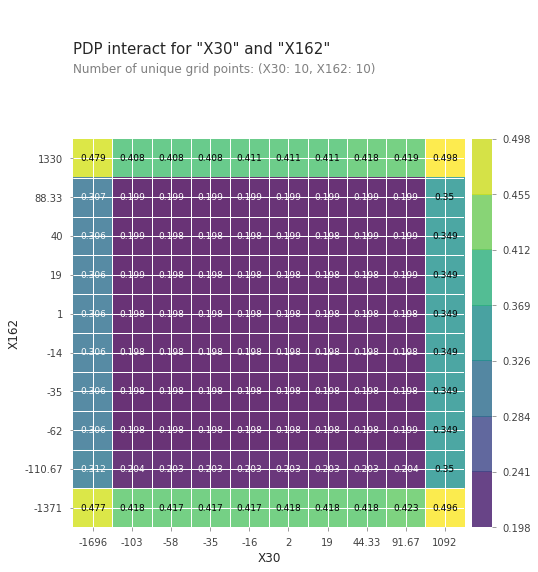

In [86]:
# multifeature partial dependency plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['X30', 'X162']

interaction = pdp_interact(
  model=pipeline, # pipeline is generic refering to your data model
  dataset=X_val,
  model_features=X_val.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

## Modeling

## Visualization